In [4]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import datetime
from tqdm import tqdm
import pandas_ta as ta

market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['adj_close'].unstack().reindex_like(P).pct_change()
income_statement = pd.read_parquet('data/US/income_statement.pq')

In [32]:
aapl = market_data.xs('AAPL',level=1)
ta.stoch(aapl['high'],aapl['low'],aapl['close']).iloc[:,0]


In [33]:
squeeze_data ={}
for ticker in tqdm(P.columns.tolist()):
    try :
        df_ticker = market_data.xs(ticker,level=1)
        squeeze = ta.stoch(df_ticker['high'],df_ticker['low'],df_ticker['close']).iloc[:,0]
        squeeze_data[ticker] = squeeze
    except :
        print(ticker,'missed')

  1%|▏         | 12/904 [00:00<00:17, 51.91it/s]

ABI missed
ACE missed


  4%|▍         | 34/904 [00:00<00:14, 59.25it/s]

AET missed


  7%|▋         | 66/904 [00:01<00:30, 27.64it/s]

AOC missed


  9%|▊         | 79/904 [00:02<00:29, 28.23it/s]

ASN missed


 11%|█         | 95/904 [00:02<00:25, 32.05it/s]

Amgen missed


 12%|█▏        | 112/904 [00:03<00:23, 33.65it/s]

BF.B missed


 14%|█▍        | 130/904 [00:03<00:21, 35.90it/s]

BMET missed
BOL missed


 15%|█▌        | 140/904 [00:04<00:19, 39.17it/s]

BRK.B missed
BSC missed


 26%|██▌       | 237/904 [00:07<00:21, 31.34it/s]

CZN missed


 28%|██▊       | 255/904 [00:07<00:16, 38.62it/s]

DJ missed


 43%|████▎     | 388/904 [00:12<00:16, 31.53it/s]

HCBK missed


 46%|████▋     | 419/904 [00:13<00:15, 30.78it/s]

IACI missed


 53%|█████▎    | 479/904 [00:15<00:12, 33.32it/s]

KRFTV missed
KSE missed


 54%|█████▍    | 491/904 [00:15<00:13, 30.75it/s]

LIZ missed


 59%|█████▉    | 532/904 [00:16<00:11, 32.29it/s]

MEL missed
MHFI missed


 64%|██████▍   | 577/904 [00:18<00:09, 32.72it/s]

MXB missed
NAVIV missed


 68%|██████▊   | 615/904 [00:19<00:09, 29.48it/s]

NWS.A missed


 81%|████████  | 730/904 [00:22<00:02, 72.67it/s]

SHLD missed
SLR missed


 87%|████████▋ | 784/904 [00:23<00:01, 67.91it/s]

TEK missed


 88%|████████▊ | 799/904 [00:23<00:01, 69.87it/s]

TRB missed


 91%|█████████▏| 825/904 [00:23<00:01, 74.10it/s]

TXU missed
UA-C missed
UA.C missed


 93%|█████████▎| 841/904 [00:23<00:01, 62.95it/s]

UVN missed
VIA.B missed


 95%|█████████▍| 855/904 [00:24<00:00, 55.87it/s]

WAG missed


 97%|█████████▋| 880/904 [00:24<00:00, 69.12it/s]

WFMI missed
WMI missed
WPI missed
WPO missed


 99%|█████████▉| 896/904 [00:24<00:00, 69.18it/s]

Wyeth missed


100%|██████████| 904/904 [00:24<00:00, 36.35it/s]


<Axes: >

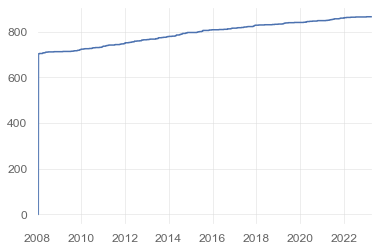

In [34]:
squeeze_data = pd.concat(squeeze_data,axis=1).reindex_like(P).ffill()
squeeze_data.count(1).plot()

C:\Users\marti\AppData\Local\Temp\ipykernel_60556\2155274693.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe      1.286
Turnover    0.463
biais       2.799
dtype: float64

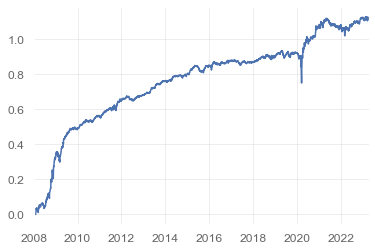

In [38]:
signal = squeeze_data[P].rank(1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
# signal = signal[P].rolling(100).rank(axis=0,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
# signal = squeeze_data[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.6] = None

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)


PNL = (signal[P].shift()*R).sum(1).loc['2008':]
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':PNL.mean()*1e4}).round(3)